# Thresholding aka pixel classification
Thresholding in image processing means to update the color value of a pixel to either white or black according to a threshold value. If the pixel value is greater than the threshold value, then set the pixel to WHITE, otherwise set it to BLACK. There are variations to thresholding as well. One of them is inverse thresholding, where we flip greater than to lesser than and everything else remains the same.

Thresholding is used to create a binary image from a grayscale image [1]. It is the simplest way to segment objects from a background.

Thresholding algorithms implemented in scikit-image can be separated in two categories:

- Histogram-based. The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).
- Local. To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time.

If you are not familiar with the details of the different algorithms and the underlying assumptions, it is often difficult to know which algorithm will give the best results. Therefore, Scikit-image includes a function to evaluate thresholding algorithms provided by the library. At a glance, you can select the best algorithm for you data without a deep understanding of their mechanisms.

In [2]:
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold
%matplotlib inline

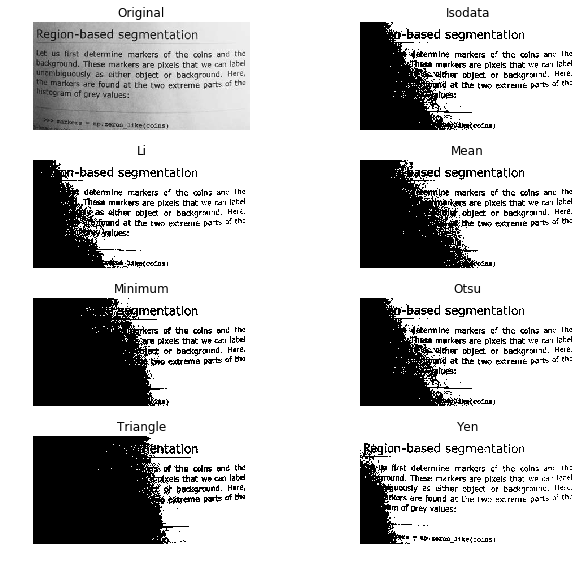

In [3]:
img = data.page()

fig, ax = try_all_threshold(img, figsize= (10,8), verbose=False)
plt.show()

### How to apply a threshold?
Now, we illustrate how to apply one of these thresholding algorithms. This example uses the `mean` value of pixel intensities. It is a simple and naive threshold value, which is sometimes used as a guess value.

In [4]:
from skimage.filters import threshold_mean

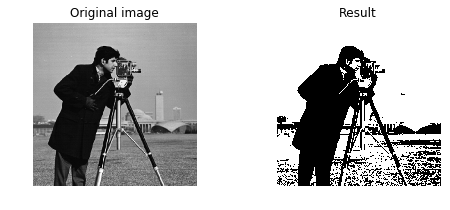

In [5]:
image = data.camera()
thresh = threshold_mean(image=image)
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

### Bimodal histogram
For pictures with a bimodal histogram, more specific algorithms can be used. For instance, the minimum algorithm takes a histogram of the image and smooths it repeatedly until there are only two peaks in the histogram.

In [6]:
from skimage.filters import threshold_minimum

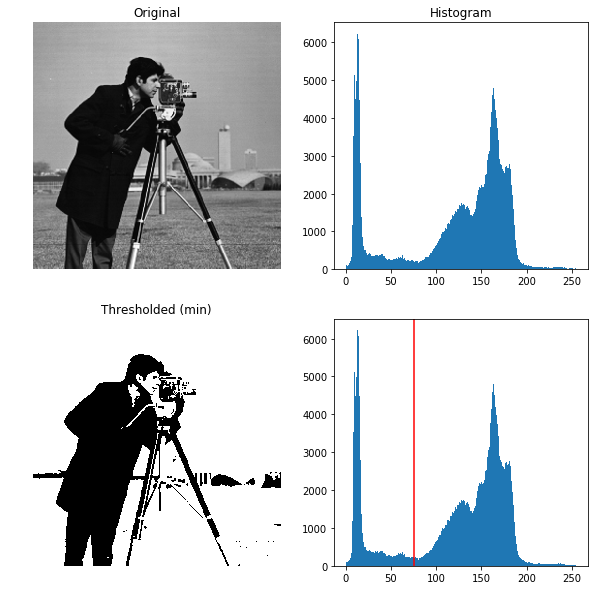

In [7]:
image = data.camera()

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

#### Otsu's method / threshold
calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

In [8]:
from skimage.filters import threshold_otsu

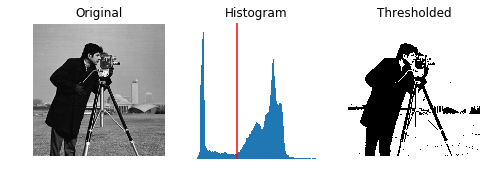

In [22]:
image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')
ax[1].axis('off')               ####### ADDING THIS TO OPEN SOURCE ###########

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Local thresholding
If the image background is relatively uniform, then you can use a global threshold value as presented above. However, if there is large variation in the background intensity, adaptive thresholding (a.k.a. local or dynamic thresholding) may produce better results. Note that local is much slower than global thresholding.

Here, we binarize an image using the `threshold_local` function, which calculates thresholds in regions with a characteristic size `block_size` surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an offset value.

In [11]:
from skimage.filters import threshold_otsu, threshold_local

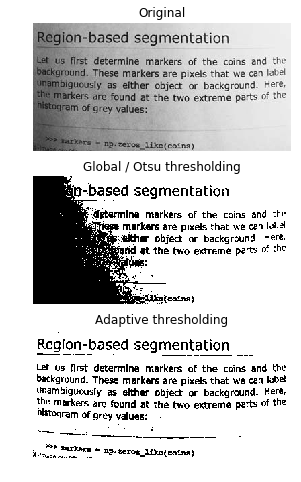

In [15]:
image = data.page()

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35  ### looking at the size of local neighborhoods here
adaptive_thresh = threshold_local(image, block_size, offset=10)
binary_adaptive = image > adaptive_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global / Otsu thresholding')

ax[2].imshow(binary_adaptive)
ax[2].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')

plt.show()

### Applying Otsu locally
For each pixel, an “optimal” threshold is determined by maximizing the variance between two classes of pixels of the local neighborhood defined by a structuring element.

The example compares the local threshold with the global threshold.

In [16]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

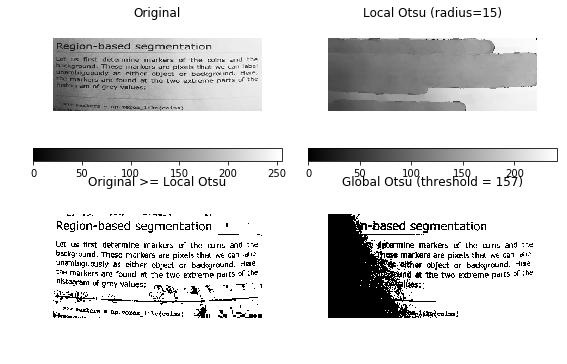

In [20]:
img = img_as_ubyte(data.page())

radius = 15
selem = disk(radius)

local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title('Local Otsu (radius=%d)' % radius)
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu' % threshold_global_otsu)
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax[3].axis('off')

plt.show()

# Edge detection

Detecting edges in an image is an important concept and has many applications. Detecting edges can help us know more about the structure and the boundary of the objects in an image. Edges are defined as parts of images where there is significant change in the pixel values while traversing the image. What this means is, say we are scanning an image from left to right, and as we scan the image, we notice that the pixel value of the previous pixel is way less than the pixel value of the current pixel.
- This implies that the current pixel can be a probable edge pixel. As we saw earlier in the chapter, an image derivative is the way of finding the change in pixel values and hence it could be a naive way of finding edges in an image. Using an image derivative, we can find pixels where there is change in the pixel values among the neighboring pixels and that pixel will probably be a part of an edge. Using only image derivatives is not very robust though. Images with a lot of noise will produce a lot of false edges, which will reduce the overall quality of your vision system.
- There are more sophisticated edge-detection techniques such as the **Sobel** and **Canny** edge detectors that we will cover in this section, which are more robust and produce fewer false results.

### // Sobel edge detector
The idea behind the Sobel edge detector is to find the pixels with a large magnitude of gradient values. We are now not only interested in the change, but also the magnitude of change (which is also the gradient). The magnitude of the gradient is calculated by finding the square root of the sum of squares of the image derivative in the x-direction and the derivative in the y-direction.

To determine how large values should be considered, we set a threshold. So after finding the gradient, we take all the gradient values, which exceed that particular threshold.

In [24]:
from skimage import io
from skimage import filters
from skimage import color

**Note that the `Sobel` function in the filter module takes a 2D array as input; therefore, you will have to convert the image into a grayscale image first.**

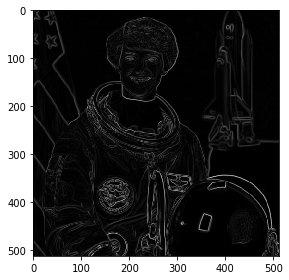

In [25]:
img = data.astronaut()
img = color.rgb2gray(img)

edge = filters.sobel(img)

io.imshow(edge)
io.show()

In [26]:
from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt

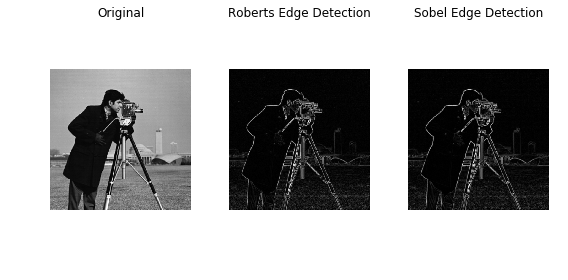

In [29]:
image = camera()
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
ax[1].set_title('Roberts Edge Detection')

ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

### // Canny edge detector
The Canny edge detector is another very important algorithm. It also uses the concept of gradients like in the Sobel edge detector, but in Sobel we only considered the magnitude of the gradient. In this we will also use the direction of the gradient to find the edges.

1. **Smoothing:** In this step, the Gaussian filter is applied to the image to reduce the noise in the image.

2. **Finding the gradient:** After removing the noise, the next step is to find the gradient magnitude and direction by calculating the x-derivative and y-derivative. The direction is important, as the gradient is always perpendicular to the edge. Therefore, if we know the direction of the gradient, we can find the direction of the edges as well.

3. **Nonmaximal suppression:** In this step, we check whether the gradient calculated is the maximum among the neighboring points lying in the positive and negative direction of the gradient; that is, whether it is the local maxima in the direction of the gradient. If it is not the local maxima, then that point is not part of an edge. In the following figure, point (x2, y2) is the local maxima, as this point has the highest change in the pixel values and it is part of the edge whereas the other two points on the line do not have a large change in the pixel values and are not the local maxima:

4. **Thresholding:** In this algorithm, we use two threshold values--the high threshold and low threshold, unlike in Sobel where we just used one threshold value. This is called hysteresis thresholding. Let's understand how this works. We select all the edge points, which are above the high threshold and then we see if there are neighbors of these points which are below the high threshold but above the low threshold; then these neighbors will also be part of that edge. But if all the points of an edge are below the high threshold, then these points will not be selected.

In [32]:
from skimage.data import astronaut
from skimage import feature

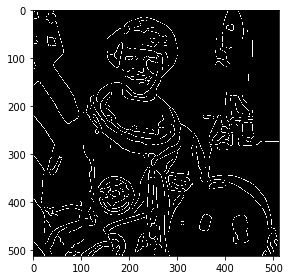

In [38]:
image = astronaut()
image = color.rgb2gray(image)

edge = feature.canny(image, 3) # Try playing around with the '3' to see how the resulting image changes
io.imshow(edge)
io.show()

## Hough line detection
In mathematics, we define a line using two parameters--a slope and a constant (the point of intersection with the y-axis). In this algorithm, we exploit the same concept and try to find the slope and constants of the lines (if any) in an image. Given any two points in the image, we substitute in the equation of the line (as shown next) and solve for the slope and intercept of the line. For example, let the two given points be (x1, y1), (x2, y2).

## Hough circle detection
Come back to this and fill it in here

## Object detection
A lot of times in a real-world situation, we have to compare two images, or search for an image of an object in a large database of images. An example could be Google Image Search, searching for a person's fingerprint in a defense organization's fingerprint database. 
- Taking a simple difference of the image with all other images from the database will not give a desired solution as there could be distortions or other small variations in the image that will give non-zero output even for matching images. So how do we solve this problem? We need ways in which we are able to describe an image that is independent of the colors, scale, rotation angle, and affine transformations. 
- In the context of computer vision, we essentially want to describe an image in terms of its features. In the last chapter, we looked at some basic features in an image such as gradients and edges but these are not sufficient to describe an image in a unique manner and are very susceptible to changes in brightness, contrast, and so on. Using only edges, we would also not be able to distinguish, between, say a clock and a steering wheel, since both will return a set of points forming a circle. This shows the need for better feature extraction techniques that can help us in such situations. 
- In this chapter, we will expand our knowledge of the features and look at more advanced image features that are able to extract finer details in the image, and are more robust and invariant to scale, color, and rotation. The following is the list of features that we will cover in this chapter:

    - Corner detection (Harris corner)
    - Cascade classifier—Local Binary Pattern (LBP)
    - Oriented FAST and Rotated BRIEF (ORB)

Before we get into the aforementioned algorithms, let us briefly go through what image features are and why they are important to what we are trying to achieve.

**To call a feature descriptor a good feature, it should be invariant to changes in scale, rotations, and translations.** 

**What this means is that if we are able to describe a car in an image in a particular way, then we should also be able to describe the car in the same way, even when the image is scaled down to half its size (scale invariant) or is rotated by 90 degrees.** 

**Having this characteristic in a feature descriptor makes it more robust to variations in the image and handle real-life situations effectively.**

## Harris corner detection
A very crude way to find corners in an image is to first find all the edges in the image and then pairwise check if the edges intersect. This might work well in some cases but will be very inefficient and impractical in real situations. Let us look at a faster corner detection algorithm—Harris corner.
- The Harris corner detector uses a sliding window over the image to calculate the variation in intensity. 
- Since corners will have large variations in the intensity values around them, we are looking for positions in the image where the sliding windows show large variations in intensity in all directions.

In [41]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.data import camera
from skimage.color import rgb2gray

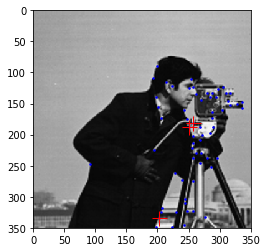

In [42]:
# Read the image
image = rgb2gray(camera())

# Computing the Harris corners in the image
corners = corner_harris(image)

# Using the corner response image we calculate the actual corners in the image
coords = corner_peaks(corners, min_distance=5)

# Decides if the corner point is an edge point or isolated peak
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 350, 350, 0))
plt.show()

## Local Binary Patterns
The Local Binary Patterns (LBP) cascade is a type of cascade classifier that is used widely in computer vision.
- In LBP, an eight-bit binary feature vector is created for each pixel in the image by considering the eight neighboring pixels (top-left, top-right, left, right, bottom-left, and bottom-right). 
- For every neighboring pixel, there is a corresponding bit, which is assigned a value 1 if the pixel value is greater than the center pixel's value, otherwise it is 0. 
- The eight-bit feature vector is treated as a binary number (later convert it to a decimal value) and using the decimal values for each pixel, a 256-bin histogram is computed. 

In [43]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import numpy as np

In [46]:
# Get three different images to test the algorithm with
brick = data.load('brick.png')
grass = data.load('grass.png')
wall = data.load('rough-wall.png')

# Calculate the LBP features for all the three images
brick_lbp = local_binary_pattern(brick, 16, 2, 'uniform')
grass_lbp = local_binary_pattern(grass, 16, 2, 'uniform')
wall_lbp = local_binary_pattern(wall, 16, 2, 'uniform')

# Next we will augment these images by rotating the images by 22 degrees
brick_rot = rotate(brick, angle = 22, resize = False)
grass_rot = rotate(grass, angle = 22, resize = False)
wall_rot = rotate(wall, angle = 22, resize = False)